In [2]:
import pandas as pd
import folium
import psycopg2
import pandas.io.sql as psql
import numpy as np
from folium import plugins

try:
    connection = psycopg2.connect(user="provider",
                                  password="sysNotMine3357",
                                  host="79.175.176.156",
                                  port="5432",
                                  database="carriotdb")
    cursor = connection.cursor()
    print("connect")
except:
    print("db error")

connect


In [8]:
%%time

start_date = "2019-12-07 10:30:00"
end_date = "2019-12-13 10:40:00"
query = """SELECT * FROM car_devicelog where device_id not in ('1','2','3') and datetime > '%s'AND datetime < '%s'
            AND latitude != 0 order by datetime""" %(start_date,end_date)

df = psql.read_sql(query , connection).drop_duplicates(keep='last')

Wall time: 2min 28s


In [7]:
d_id = 865067024755277
df_tmp = df.where(df['device_id'] == str(d_id))
df_tmp.dropna(subset =['device_id'] ,inplace= True)
c1 = int(len(df_tmp)*0.25)
c2 = int(len(df_tmp)*0.50)
c3 = int(len(df_tmp)*0.75)
l_1 = [df_tmp.loc[df_tmp.index[c1],'latitude'] , df_tmp.loc[df_tmp.index[c1],'longitude']]
l_2 = [df_tmp.loc[df_tmp.index[c2],'latitude'] , df_tmp.loc[df_tmp.index[c2],'longitude']]
l_3 = [df_tmp.loc[df_tmp.index[c3],'latitude'] , df_tmp.loc[df_tmp.index[c3],'longitude']]
#print(l_1)
#print(df_tmp)
m = folium.Map(location=l_1)
folium.Marker(location=l_1,popup='1').add_to(m)
folium.Marker(location=l_2,popup='2').add_to(m)
folium.Marker(location=l_3,popup='3').add_to(m)

antpath = plugins.AntPath(locations=[l_1 , l_2 , l_3])
antpath.add_to(m)
print (len(df_tmp))
m

75621


In [6]:
original_df=pd.read_csv('file_name_3.csv')
original_df=original_df[original_df['datetime'] > '2019-12-21' and original_df['datetime'] < '2019-12-27']
original_df=original_df.iloc[:350000,:]
o_train = original_df[original_df['datetime'] < '2020-01-03']
o_test = original_df[original_df['datetime'] > '2020-01-03']
print(len(original_df))
print(len(o_train))
print(len(o_test))
#original_df.to_csv('origin.csv')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [295]:
print(len(o_train['device_id'].unique()))
o_train['device_id'].unique()


7


array([865067024755277, 865067024755384, 865067024755434, 865067024758651,
       865067024755392, 865067024755772, 865067024755517], dtype=int64)

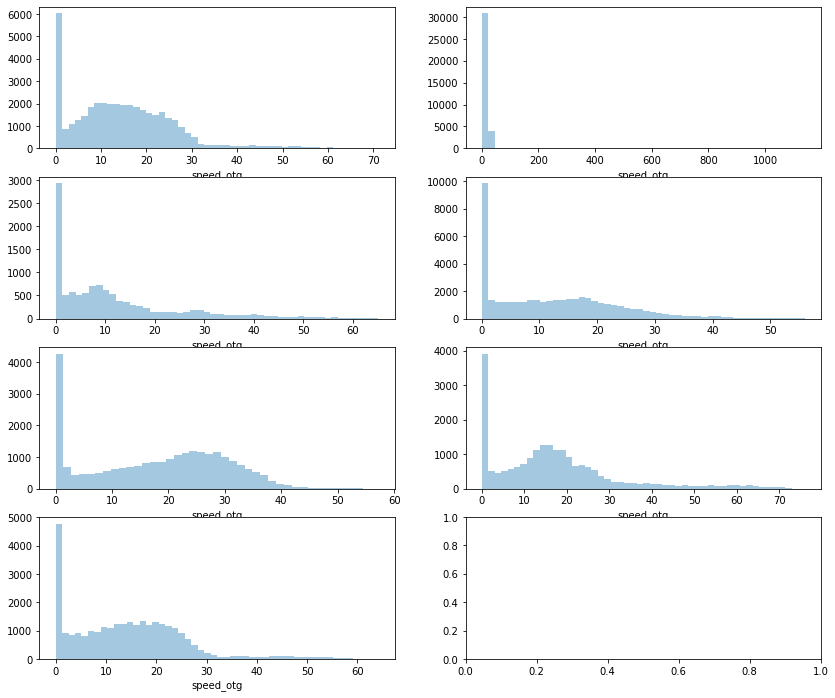

In [5]:

fig, axs = plt.subplots(4,2,figsize=(14,12))
sb.distplot(o_train.loc[o_train['device_id']==865067024755277,'speed_otg'],kde = False,ax=axs[0][0])
sb.distplot(o_train.loc[o_train['device_id']==865067024755384,'speed_otg'],kde = False,ax=axs[0][1])
sb.distplot(o_train.loc[o_train['device_id']==865067024755434,'speed_otg'],kde = False,ax=axs[1][0])
sb.distplot(o_train.loc[o_train['device_id']==865067024758651,'speed_otg'],kde = False,ax=axs[1][1])
sb.distplot(o_train.loc[o_train['device_id']==865067024755392,'speed_otg'],kde = False,ax=axs[2][0])
sb.distplot(o_train.loc[o_train['device_id']==865067024755772,'speed_otg'],kde = False,ax=axs[2][1])
sb.distplot(o_train.loc[o_train['device_id']==865067024755517,'speed_otg'],kde = False,ax=axs[3][0])

plt.show()

In [6]:
def create_tuples(df):
    df = df.reindex(columns=['device_id','datetime','speed_otg'])
    df = df.sort_values(by = ['device_id','datetime'])
    df['normal_speed'] = df.groupby('device_id')['speed_otg'].rolling(5,center=True).mean().reset_index(0,drop=True)
    df = df.dropna()
    s = df.groupby('device_id')['normal_speed'].diff().fillna(0)
    df['variation'] = np.where(s.eq(0), np.nan, np.where(s.gt(0), 'increase','decrease'))
    df = df.dropna()
    df['subgroup'] = ((df['variation'] != df['variation'].shift(1)) & (df['device_id'] == df['device_id'].shift(1))).cumsum()
    df['min'] = df.groupby('subgroup')['normal_speed'].transform(lambda x: np.min(x)) 
    df['max'] = df.groupby('subgroup')['normal_speed'].transform(lambda x: np.max(x)) 
    df['delta_time'] = df.groupby('subgroup')['normal_speed'].transform(lambda x: len(x)) 
    df['delta_speed'] = df['max'] - df['min']
    df = df.drop_duplicates(['subgroup'],keep='first')
    df = df[['device_id','normal_speed','delta_speed','delta_time']].reset_index(0,drop=True)
    return df

In [26]:
tup_train = create_tuples(o_train)
print(len(tup_train))
tup_test = create_tuples(o_test)
print(len(tup_test))
tup_test

31975
28108


,device_id,normal_speed,delta_speed,delta_time
0,865067024755277,0.000000,0.000000,4.0
1,865067024755277,0.055560,0.000000,1.0
2,865067024755277,0.055560,0.000000,1.0
3,865067024755277,0.062968,0.000000,1.0
4,865067024755277,0.062968,0.000000,1.0
...,...,...,...,...
28103,865067024758651,0.203720,0.000000,1.0
28104,865067024758651,0.207424,0.540784,7.0
28105,865067024758651,0.733392,0.351880,12.0
28106,865067024758651,0.414848,0.340768,14.0


In [ ]:
sb.pairplot(tup_test)

In [29]:
tup_train['device_id']= tup_train['device_id'].apply(lambda x: int(re.findall('86506702475(\S+)',str(x))[0]))
tup_test['device_id']= tup_test['device_id'].apply(lambda x: int(re.findall('86506702475(\S+)',str(x))[0]))


In [9]:
def preprocess(df):
    tdf=pd.DataFrame(columns=['device_id','m1','m2','m3','m4','m5','m6','var1','var2','var3','var4','var5','var6'])
    for n,i in enumerate(df['device_id'].unique()):
        print(n)
        x_tup=df.loc[df['device_id']==i, ['normal_speed','delta_speed','delta_time']].to_numpy().tolist()
        for j in range(200):
            tuples=random.sample(x_tup,50)
            kmeans = KMeans(n_clusters=3)
            kmeans.fit(tuples)
            temp=pd.DataFrame(tuples,columns=['V','DeltaV','T'])
            temp=temp.drop(['V'],axis=1)
            temp['label']=kmeans.labels_
            temp.loc[temp['label']==0,'DeltaV']=np.log(temp.loc[temp['label']==0,'DeltaV']+1)
            temp.loc[temp['label']==0,'T']=np.log(temp.loc[temp['label']==0,'T']+1)
            temp.loc[temp['label']==1,'DeltaV']=np.log(temp.loc[temp['label']==1,'DeltaV']+1)
            temp.loc[temp['label']==1,'T']=np.log(temp.loc[temp['label']==1,'T']+1)
            temp.loc[temp['label']==2,'DeltaV']=np.log(temp.loc[temp['label']==2,'DeltaV']+1)
            temp.loc[temp['label']==2,'T']=np.log(temp.loc[temp['label']==2,'T']+1)
            m1=temp.loc[temp['label']==0,'DeltaV'].mean()
            m2=temp.loc[temp['label']==0,'T'].mean()
            m3=temp.loc[temp['label']==1,'DeltaV'].mean()
            m4=temp.loc[temp['label']==1,'T'].mean()
            m5=temp.loc[temp['label']==2,'DeltaV'].mean()
            m6=temp.loc[temp['label']==2,'T'].mean()
            var1=np.var(temp.loc[temp['label']==0,'DeltaV'])
            var2=np.var(temp.loc[temp['label']==0,'T'])
            var3=np.var(temp.loc[temp['label']==1,'DeltaV'])
            var4=np.var(temp.loc[temp['label']==1,'T'])
            var5=np.var(temp.loc[temp['label']==2,'DeltaV'])
            var6=np.var(temp.loc[temp['label']==2,'T'])
            row= {'device_id':[i],
                  'm1':[m1] ,
                  'm2':[m2] ,
                  'm3':[m3] ,
                  'm4':[m4] ,
                  'm5':[m5] ,
                  'm6':[m6] ,
                  'var1':[var1] ,
                  'var2':[var2] ,
                  'var3':[var3] ,
                  'var4':[var4],
                  'var5':[var5],
                  'var6':[var6]}
            df1 = pd.DataFrame(row) 
            tdf = tdf.append(df1, ignore_index = True,sort=False)
    return tdf

In [10]:
test=preprocess(tup_test)
#test=preprocess2(tup_test)
#test=preprocess3(tup_test)
print(len(test))
train=preprocess(tup_train)
#train=preprocess2(tup_train)
#train=preprocess3(tup_train)
print(len(train))
train

0
1
2
3
4
5
6
1400
0
1
2
3
4
5
6
1400


,device_id,m1,m2,m3,m4,m5,m6,var1,var2,var3,var4,var5,var6
0,5277,1.560184,1.715274,0.646642,1.323874,2.993740,2.607709,1.060108,0.373313,0.567055,0.335800,0.035636,0.089019
1,5277,0.899936,1.559657,1.196332,1.686872,2.668995,2.473424,0.595596,0.301676,0.913820,0.467944,0.042474,0.058110
2,5277,1.233037,1.663493,1.471679,2.009354,2.715836,2.214597,1.076070,0.439853,1.015773,0.346680,0.045966,0.169471
3,5277,0.404105,1.403414,1.182016,1.812745,2.760650,2.618751,0.266134,0.286840,0.529722,0.172413,0.090310,0.064242
4,5277,1.884004,2.014173,1.338416,1.811152,0.113322,1.030069,0.564395,0.231858,1.318538,0.441135,0.061184,0.201961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8651,0.263229,1.202778,1.109085,1.543036,2.684478,2.364275,0.293778,0.251298,1.122934,0.385395,0.089015,0.123168
1396,8651,0.394131,1.313596,2.380850,2.409458,1.756984,2.142758,0.376305,0.219204,0.201230,0.160819,0.859016,0.327801
1397,8651,0.537311,1.359542,1.074786,1.590797,2.735766,2.443076,0.616680,0.342122,0.516467,0.236473,0.080535,0.025648
1398,8651,1.987475,2.055868,0.219903,1.263727,1.033695,1.718831,0.676457,0.229157,0.271032,0.417099,0.587279,0.378339


In [11]:
y_test=test['device_id']
y_train=train['device_id']
y_test=y_test.astype('int')
y_train=y_train.astype('int')
x_train=train.iloc[:,1:]
x_test=test.iloc[:,1:]

In [12]:
scaler = MinMaxScaler()
scaled_xtrain=scaler.fit_transform(x_train)    
scaled_xtrain=pd.DataFrame(scaled_xtrain)
scaled_xtest=scaler.fit_transform(x_test)
scaled_xtest=pd.DataFrame(scaled_xtest)

In [13]:
svc_model = SVC(kernel='linear',C=10,gamma=1)
svc_model.fit(scaled_xtrain,y_train)
y_predict=svc_model.predict(scaled_xtest)

In [14]:

metrics.accuracy_score(y_test, y_predict)

0.3364285714285714

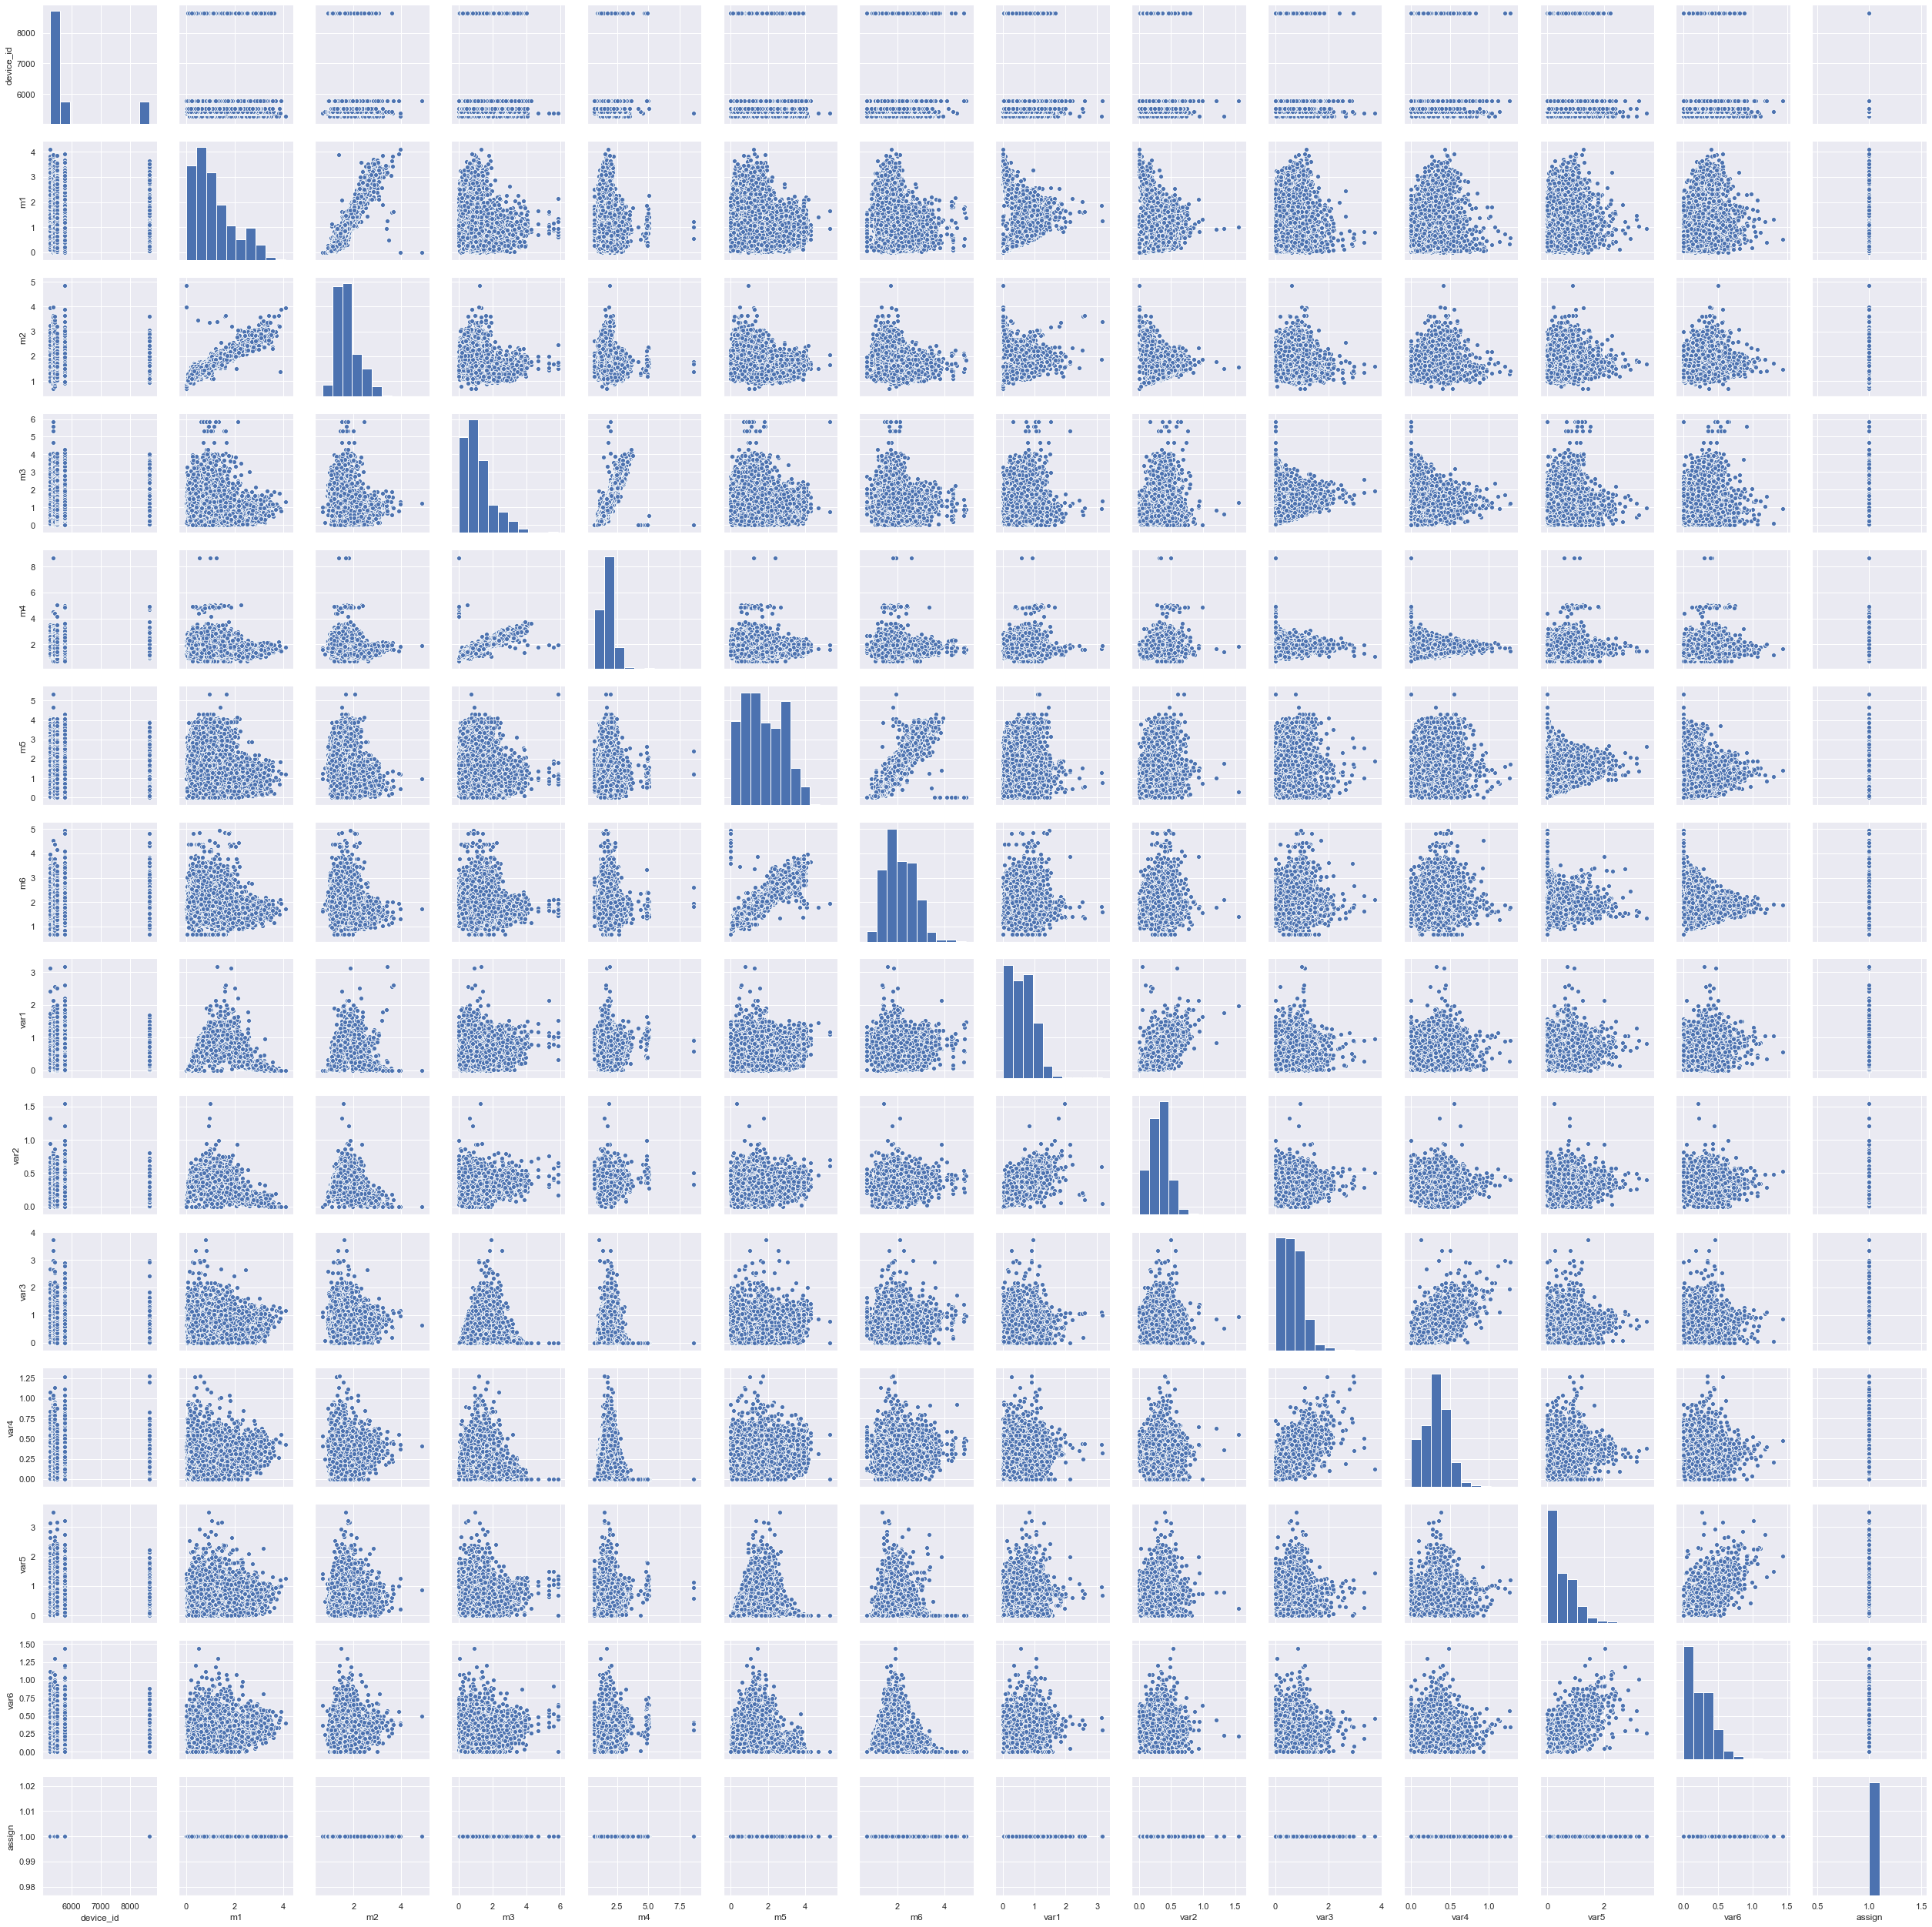

In [245]:
sb.pairplot(train)

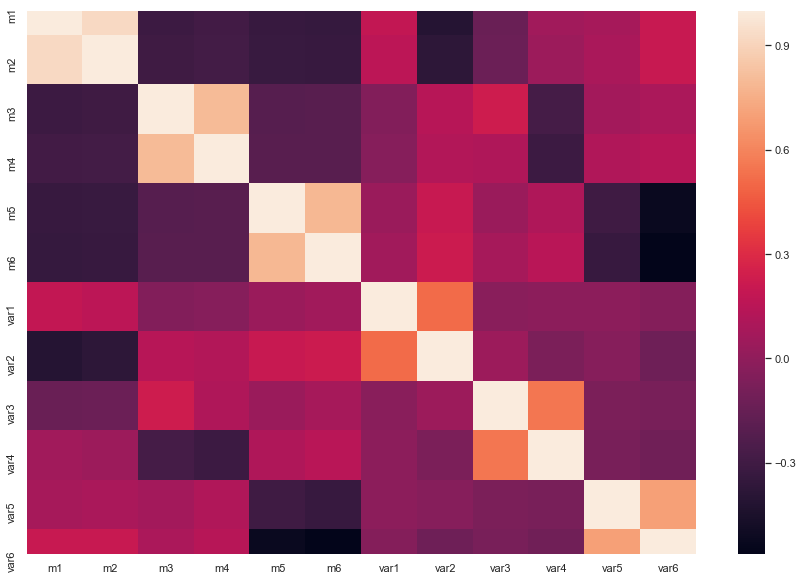

In [222]:
sb.heatmap(test.corr())

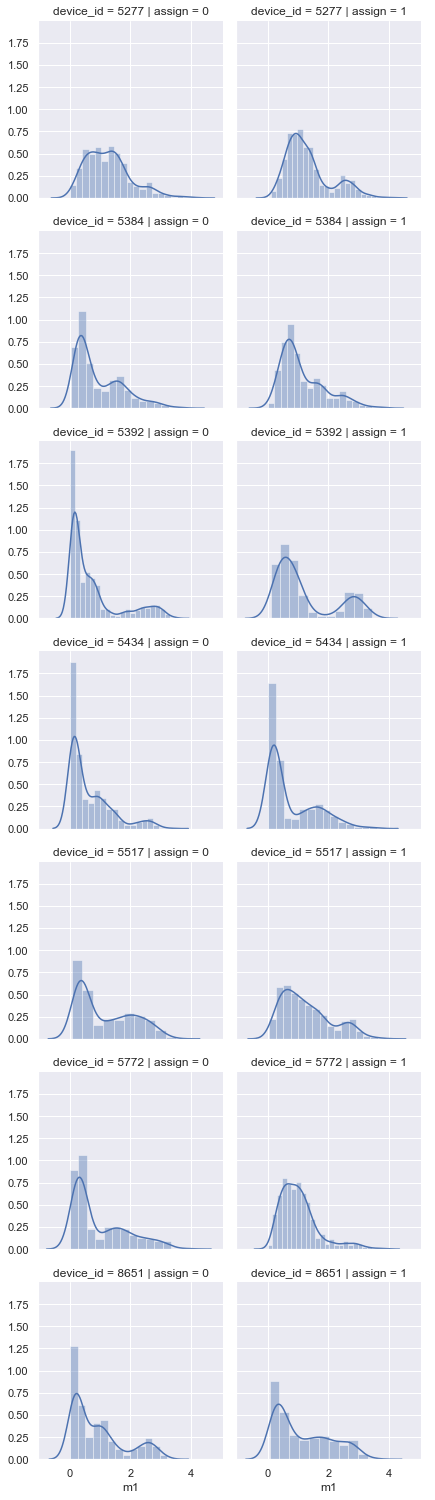

In [223]:
test['assign']=0
train['assign']=1
sb.set(rc={"figure.figsize": (15, 10)})
concatenated = pd.concat([test.assign(dataset='test'), train.assign(dataset='train')])
g = sb.FacetGrid(concatenated, row="device_id",col='assign')
g.map(sb.distplot,'m1')
g.add_legend();

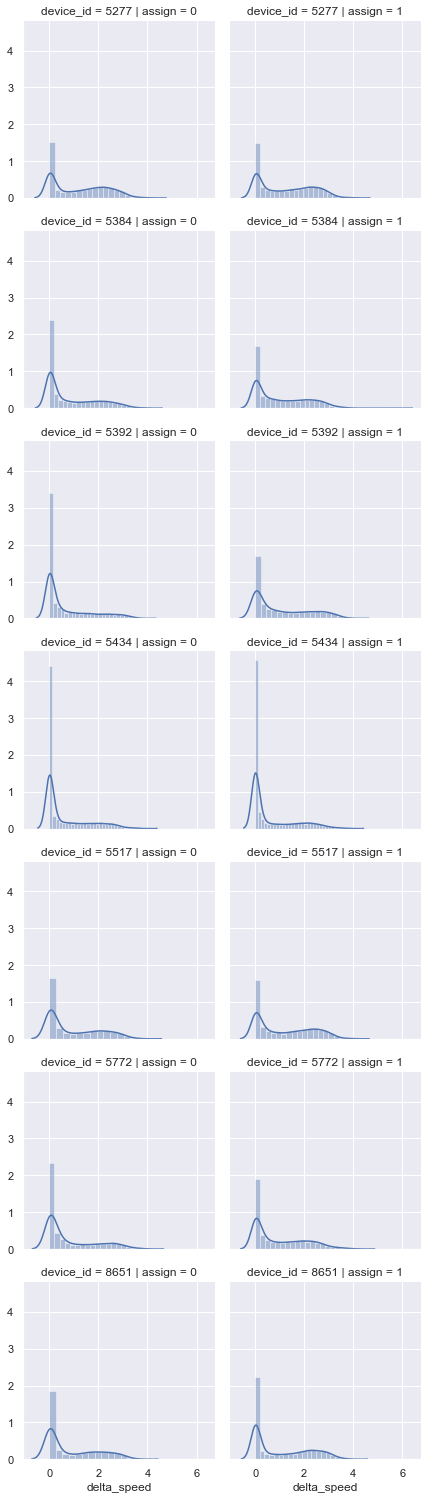

In [208]:
test['assign']=0
train['assign']=1
sb.set(rc={"figure.figsize": (15, 10)})
concatenated = pd.concat([test.assign(dataset='test'), train.assign(dataset='train')])
g = sb.FacetGrid(concatenated, row="device_id",col='assign')
g.map(sb.distplot,'delta_speed')
g.add_legend();

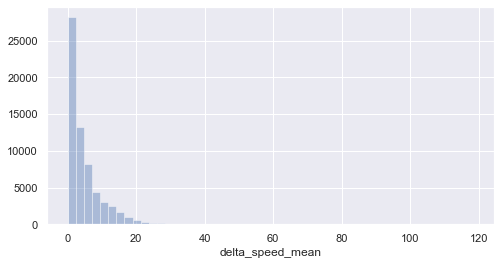

In [41]:
sb.set(rc={"figure.figsize": (8, 4)})
sb.distplot(train['delta_speed_mean'],kde = False)

plt.show()

0.2914285714285714

In [ ]:
tdf=pd.DataFrame()

for n,i in enumerate(tup_test['device_id'].unique()):
    print(n)
    temp=tup_test.loc[tup_test['device_id']==i, ['device_id','normal_speed','delta_speed','delta_time']]
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(temp)
    temp=temp.drop(['normal_speed'],axis=1)
    temp['label']=kmeans.labels_
    df1=pd.DataFrame()
    temp.loc[temp['label']==0,'delta_speed']=np.log(temp.loc[temp['label']==0,'delta_speed']+1)
    temp.loc[temp['label']==0,'delta_time']=np.log(temp.loc[temp['label']==0,'delta_time']+1)
    temp.loc[temp['label']==1,'delta_speed']=np.log(temp.loc[temp['label']==1,'delta_speed']+1)
    temp.loc[temp['label']==1,'delta_time']=np.log(temp.loc[temp['label']==1,'delta_time']+1)
    temp.loc[temp['label']==2,'delta_speed']=np.log(temp.loc[temp['label']==2,'delta_speed']+1)
    temp.loc[temp['label']==2,'delta_time']=np.log(temp.loc[temp['label']==2,'delta_time']+1)

    temp['deta_speed_mean']=temp.groupby('label')['delta_speed'].rolling(5,center=True).mean().reset_index(0,drop=True)
    temp['deta_T_mean']=temp.groupby('label')['delta_time'].rolling(5,center=True).mean().reset_index(0,drop=True)

    temp= temp.dropna()
    tdf = tdf.append(temp, ignore_index = True,sort=False)
tdf


In [16]:
def preprocess2(df):
    tdf=pd.DataFrame()

    for n,i in enumerate(df['device_id'].unique()):
        #print(n)
        temp=df.loc[df['device_id']==i, ['device_id','normal_speed','delta_speed','delta_time']]
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(temp)
        #temp=temp.drop(['normal_speed'],axis=1)
        temp['label']=kmeans.labels_
        df1=pd.DataFrame()
        temp.loc[temp['label']==0,'delta_speed']=np.log(temp.loc[temp['label']==0,'delta_speed']+1)
        temp.loc[temp['label']==0,'delta_time']=np.log(temp.loc[temp['label']==0,'delta_time']+1)
        temp.loc[temp['label']==1,'delta_speed']=np.log(temp.loc[temp['label']==1,'delta_speed']+1)
        temp.loc[temp['label']==1,'delta_time']=np.log(temp.loc[temp['label']==1,'delta_time']+1)
        temp.loc[temp['label']==2,'delta_speed']=np.log(temp.loc[temp['label']==2,'delta_speed']+1)
        temp.loc[temp['label']==2,'delta_time']=np.log(temp.loc[temp['label']==2,'delta_time']+1)
        temp.loc[temp['label']==0,'normal_speed']=np.log(temp.loc[temp['label']==0,'normal_speed']+1)
        temp.loc[temp['label']==1,'normal_speed']=np.log(temp.loc[temp['label']==1,'normal_speed']+1)
        temp.loc[temp['label']==2,'normal_speed']=np.log(temp.loc[temp['label']==2,'normal_speed']+1)
        temp['delta_NS_mean']=temp.groupby('label')['normal_speed'].rolling(5,center=True).mean().reset_index(0,drop=True)
        temp['delta_NS_var']=temp.groupby('label')['normal_speed'].rolling(5,center=True).var().reset_index(0,drop=True)
        temp['delta_speed_mean']=temp.groupby('label')['delta_speed'].rolling(5,center=True).mean().reset_index(0,drop=True)
        temp['delta_speed_var']=temp.groupby('label')['delta_speed'].rolling(5,center=True).var().reset_index(0,drop=True)
        temp['delta_T_mean']=temp.groupby('label')['delta_time'].rolling(5,center=True).mean().reset_index(0,drop=True)
        temp['delta_T_var']=temp.groupby('label')['delta_time'].rolling(5,center=True).var().reset_index(0,drop=True)
        temp['acceleration'] =  df.apply(lambda row : row['delta_speed']/row['delta_time'], axis = 1) 
        temp['acceleration']=np.log(temp['acceleration']+1)
        temp=temp.drop(['label','delta_time'],axis=1)
        temp= temp.dropna()
        #temp=temp[temp.delta_speed_mean!=0]
        tdf = tdf.append(temp, ignore_index = True,sort=False)
    return tdf


In [17]:
test2=preprocess2(tup_test)
print(len(test))
train2=preprocess2(tup_train)
print(len(train))
train

1400
1400


,device_id,m1,m2,m3,m4,m5,m6,var1,var2,var3,var4,var5,var6
0,5277,1.560184,1.715274,0.646642,1.323874,2.993740,2.607709,1.060108,0.373313,0.567055,0.335800,0.035636,0.089019
1,5277,0.899936,1.559657,1.196332,1.686872,2.668995,2.473424,0.595596,0.301676,0.913820,0.467944,0.042474,0.058110
2,5277,1.233037,1.663493,1.471679,2.009354,2.715836,2.214597,1.076070,0.439853,1.015773,0.346680,0.045966,0.169471
3,5277,0.404105,1.403414,1.182016,1.812745,2.760650,2.618751,0.266134,0.286840,0.529722,0.172413,0.090310,0.064242
4,5277,1.884004,2.014173,1.338416,1.811152,0.113322,1.030069,0.564395,0.231858,1.318538,0.441135,0.061184,0.201961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8651,0.263229,1.202778,1.109085,1.543036,2.684478,2.364275,0.293778,0.251298,1.122934,0.385395,0.089015,0.123168
1396,8651,0.394131,1.313596,2.380850,2.409458,1.756984,2.142758,0.376305,0.219204,0.201230,0.160819,0.859016,0.327801
1397,8651,0.537311,1.359542,1.074786,1.590797,2.735766,2.443076,0.616680,0.342122,0.516467,0.236473,0.080535,0.025648
1398,8651,1.987475,2.055868,0.219903,1.263727,1.033695,1.718831,0.676457,0.229157,0.271032,0.417099,0.587279,0.378339


In [19]:
y_test2=test2['device_id']
y_train2=train2['device_id']
y_test2=y_test2.astype('int')
y_train2=y_train2.astype('int')
x_train2=train2.iloc[:,1:]
x_test2=test2.iloc[:,1:]

scaler = MinMaxScaler()
scaled_xtrain2=scaler.fit_transform(x_train2)    
scaled_xtrain2=pd.DataFrame(scaled_xtrain2)
scaled_xtest2=scaler.fit_transform(x_test2)
scaled_xtest2=pd.DataFrame(scaled_xtest2)

svc_model = SVC(kernel='linear',C=10,gamma=1)
svc_model.fit(scaled_xtrain2,y_train2)
y_predict2=svc_model.predict(scaled_xtest2)

metrics.accuracy_score(y_test2, y_predict2)

0.1894447616328861

In [313]:
def preprocess3(df):
    tdf=pd.DataFrame()
    temp['delta_speed']=np.log(temp.loc[df['device_id']==i,['delta_speed']]+1)
    temp['delta_time']=np.log(temp.loc[df['device_id']==i,['delta_time']]+1)
    temp['delta_speed_mean']=temp['delta_speed'].rolling(5,center=True).mean().reset_index(0,drop=True)
    temp['acceleration'] =df.apply(lambda row : row['delta_speed']/row['delta_time'], axis = 1) 
    temp['acceleration']=np.log(temp['acceleration']+1)
    temp=temp.drop(['delta_time'],axis=1)
    temp= temp.dropna()
    print(temp)
    tdf = tdf.append(temp, ignore_index = True,sort=False)
    return tdf


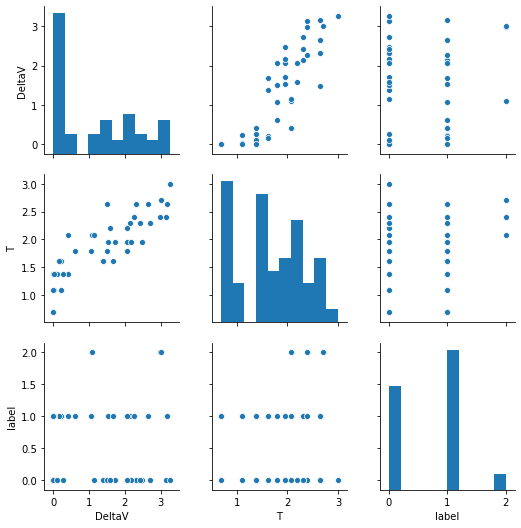

In [35]:

tdf=pd.DataFrame(columns=['device_id','m1','m2','m3','m4','m5','m6','var1','var2','var3','var4','var5','var6'])
#for n,i in enumerate(df['device_id'].unique()):
#print(n)
x_tup=tup_test.loc[tup_test['device_id']==5277, ['normal_speed','delta_speed','delta_time']].to_numpy().tolist()
#for j in range(200):
tuples=random.sample(x_tup,50)
kmeans = KMeans(n_clusters=3)
kmeans.fit(tuples)
temp1=pd.DataFrame(tuples,columns=['V','DeltaV','T'])
temp['label']=kmeans.labels_
temp.loc[temp['label']==0,'DeltaV']=np.log(temp.loc[temp['label']==0,'DeltaV']+1)
temp.loc[temp['label']==0,'T']=np.log(temp.loc[temp['label']==0,'T']+1)
temp.loc[temp['label']==1,'DeltaV']=np.log(temp.loc[temp['label']==1,'DeltaV']+1)
temp.loc[temp['label']==1,'T']=np.log(temp.loc[temp['label']==1,'T']+1)
temp.loc[temp['label']==2,'DeltaV']=np.log(temp.loc[temp['label']==2,'DeltaV']+1)
temp.loc[temp['label']==2,'T']=np.log(temp.loc[temp['label']==2,'T']+1)
m1=temp.loc[temp['label']==0,'DeltaV'].mean()
m2=temp.loc[temp['label']==0,'T'].mean()
m3=temp.loc[temp['label']==1,'DeltaV'].mean()
m4=temp.loc[temp['label']==1,'T'].mean()
m5=temp.loc[temp['label']==2,'DeltaV'].mean()
m6=temp.loc[temp['label']==2,'T'].mean()
var1=np.var(temp.loc[temp['label']==0,'DeltaV'])
var2=np.var(temp.loc[temp['label']==0,'T'])
var3=np.var(temp.loc[temp['label']==1,'DeltaV'])
var4=np.var(temp.loc[temp['label']==1,'T'])
var5=np.var(temp.loc[temp['label']==2,'DeltaV'])
var6=np.var(temp.loc[temp['label']==2,'T'])
row= {'device_id':[5277],
      'm1':[m1] ,
      'm2':[m2] ,
      'm3':[m3] ,
      'm4':[m4] ,
      'm5':[m5] ,
      'm6':[m6] ,
      'var1':[var1] ,
      'var2':[var2] ,
      'var3':[var3] ,
      'var4':[var4],
      'var5':[var5],
      'var6':[var6]}
df1 = pd.DataFrame(row) 
tdf = tdf.append(df1, ignore_index = True,sort=False)
sb.pairplot(temp)

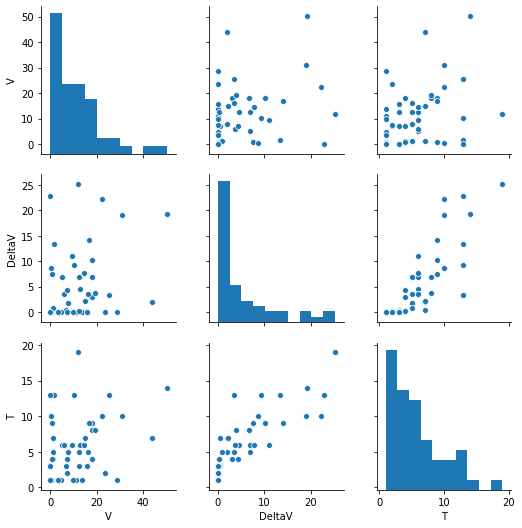

In [36]:
sb.pairplot(temp1)

In [33]:
tdf

,device_id,m1,m2,m3,m4,m5,m6,var1,var2,var3,var4,var5,var6
0,5277,0.283374,1.297498,2.321519,2.370594,1.71004,2.12767,0.248762,0.232275,0.279464,0.125216,1.004879,0.209276
